# 0. Imports

In [1]:
from dotenv import load_dotenv
import os
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate, QFT
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
import matplotlib.pyplot as plt
from fractions import Fraction
from math import floor, gcd, log, ceil
import numpy as np
import datetime


# 1. Configurações Iniciais

## 1.1. Carrega variáveis de ambiente

In [2]:
load_dotenv()
API_KEY = os.getenv('IBM_QUANTUM_API_KEY')
INSTANCE_CRN = os.getenv('IBM_QUANTUM_INSTANCE_CRN')

## 1.2. Configura conta da IBM Cloud com instância especificada

In [4]:
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=API_KEY,
    instance=INSTANCE_CRN, 
    overwrite=True,
    set_as_default=True
)

# 2. Códigos

## 2.1. Roda medição de um qubit aplicado a uma porta Hadamard

In [5]:
# 1. Inicializar serviço (assume que você já autenticou com save_account)
service = QiskitRuntimeService()

# 2. Selecionar o backend real menos ocupado
backend = service.least_busy(operational=True, simulator=False)

# 3. Criar circuito simples (e medir)
qc = QuantumCircuit(1)
qc.h(0)
qc.measure_all()

# 4. Transpilar para o backend
qc_isa = transpile(qc, backend=backend)

# 5. Criar Sampler informando o backend — usando o modo moderno:
sampler = Sampler(mode=backend)

# 6. Enviar o job (como lista de circuitos)
job = sampler.run([qc_isa], shots=1024)
job_id = job.job_id()
# print("Job ID:", job_id)
print("Status:", job.status())

management.get:WARNING:2025-10-05 18:53:14,891: Loading default saved account


Status: QUEUED


Status: DONE
Counts: {'1': 507, '0': 517}


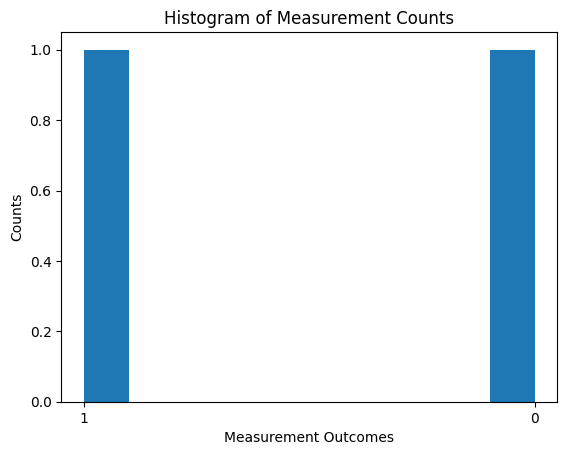

In [6]:
job = service.job(job_id)
print("Status:", job.status())

if job.status() == "DONE":
    # 7. Capturar o resultado
    result = job.result()
    counts = result[0].data.meas.get_counts()

    # 8. Visualizar resultados
    print("Counts:", counts)
    plt.hist(counts)
    plt.title("Histogram of Measurement Counts")
    plt.xlabel("Measurement Outcomes")
    plt.ylabel("Counts")

    plt.show()

else:
    print("Job not completed")

## 2.2. Descobrindo número de qubits do backend utilizado

In [82]:
backends = service.backends(simulator=False, operational=True)
for backend in backends:
    print(f"Backend: {backend.name},\tQubits: {backend.num_qubits},\tOperational: {backend.status().operational}")


Backend: ibm_brisbane,	Qubits: 127,	Operational: True
Backend: ibm_torino,	Qubits: 133,	Operational: True


## 2.3. Criando código do algoritmo de Shor

### 2.3.1. Frações Contínuas

In [83]:
def continued_fraction(x, max_denominator):
    """Aproxima x como uma fração com denominador ≤ max_denominator"""
    frac = Fraction(x).limit_denominator(max_denominator)
    return frac.numerator, frac.denominator


### 2.3.2. Porta de operação modular

In [94]:
def c_mod_mult_gate(b, N):
  """
  Retorna a versão controlada da porta modular que implementa |x⟩ → |b·x mod N⟩
  controlada por 1 qubit.

  Parâmetros:
  - b: inteiro multiplicador (coprimo de N)
  - N: inteiro módulo

  Retorna:
  - Uma UnitaryGate controlada (1 qubit de controle)
  """
  if gcd(b, N) > 1:
      raise ValueError(f"Erro: gcd({b}, {N}) > 1 — b e N devem ser coprimos.")

  n = floor(log(N - 1, 2)) + 1  # Número de qubits necessários para representar N
  U = np.zeros((2**n, 2**n))

  for x in range(N):
      U[b * x % N][x] = 1
  for x in range(N, 2**n):
      U[x][x] = 1  # Mapeia fora do domínio válido para identidade

  base_gate = UnitaryGate(U, label=f"{b}×mod{N}")
  controlled_gate = base_gate.control()  # Cria a versão com 1 qubit de controle

  return controlled_gate

### 2.3.3. Define circuito de *Order Finding*

In [168]:
def order_finding_circuit(N, a, m=None, view_circuit=False):
    if m is None:
      m = ceil(2 * log(N, 2)) + 1  # Número de qubits de controle
    n = floor(log(N - 1, 2)) + 1  # Número de qubits de dados (registrador modular)

    # Registradores
    q_control = QuantumRegister(m, 'ctrl')
    q_data = QuantumRegister(n, 'data')
    c_out = ClassicalRegister(m, 'c')
    qc = QuantumCircuit(q_control, q_data, c_out)

    # Estado inicial |1⟩ no registrador de dados
    qc.x(q_data[0])

    # Hadamard em todos os qubits de controle
    for i in range(m):
        qc.h(q_control[i])

    # Aplicar operações controladas: a^(2^i) mod N
    for i in range(m):
        exponent = 2 ** i
        mod_gate = c_mod_mult_gate(pow(a, exponent, N), N)
        qc.append(mod_gate, [i] + list(range(m, m + n)))

    # Aplicar QFT† no controle
    qft_dagger = QFT(num_qubits=m, inverse=True, do_swaps=True).decompose()
    qc.append(qft_dagger, q_control)

    # Medir o registrador de controle
    qc.measure(q_control, c_out)

    if view_circuit:
        display(qc.draw(output='mpl'))

    return qc

### 2.3.4. Executa o problema de *Order Finding* no computador quântico

In [159]:
def order_finding(N, a, backend = None, shots = 1000): 
    """_summary_
    N: inteiro positivo (modulus)
    a: inteiro positivo (multiplicador)
    backend: backend do Qiskit (opcional, pode ser None para ser simulação)
    shots: número de execuções do circuito (default: 1000)
    
    Resultado:
    - Retorna o objeto "job".
    """
    # Calcula o número de qubits de controle necessário
    m = 4#ceil(2 * log(N, 2)) + 1  # Número de qubits de controle teórico
    print(f"Calculando: m = {m}")
    
    # Cria o circuito de busca de ordem
    qc = order_finding_circuit(N=N, a=a, m=m, view_circuit=False)
    
    # Se backend não for fornecido, usa o simulador
    if backend is None:

        
        # === Simulação local ===
        backend = Aer.get_backend('qasm_simulator')
        transpiled = transpile(qc, backend)
        job = backend.run(transpiled, shots=shots, memory=True)

        return job
    
    else:
        # === Execução em backend real ===
        qc_transp = transpile(qc, backend=backend)

        # === Criar Sampler informando o backend — usando o modo moderno ===
        sampler = Sampler(mode=backend)

        # === Enviar o job (como lista de circuitos) ===
        job = sampler.run([qc_transp], shots=shots)
        # print("Job ID:", job.job_id())
        print("Status:", job.status())     
        
        return job

In [169]:
def process_job(job, m, N, a, real=None):
    result = job.result()

    if real is None:
        # === Simulação local ===
        print("Processando resultado da simulação local...")
        readings = result.get_counts()
    else:
        print("Processando resultado do backend...")
        pub = result[0]
        data_bin = pub.data
        bitarray = data_bin.c
        readings = bitarray.get_counts()
        
    
    measured_bin = max(readings, key=readings.get) # Leitura mais significativa
    measured_int = int(measured_bin, 2)

    # === Calcular fase observada ===
    phase = measured_int / (2 ** m)

    # === Estimar r com frações contínuas ===
    print(f"Phase encontrada = {phase}, para N = {N} e a = {a}")
    r = continued_fraction(phase, N)[1]
    
    return r

In [170]:
# Selecionar novamente o backend real menos ocupado
backend = service.least_busy(operational=True, simulator=False)

# Executar a busca de ordem com N=15, a=7, e o backend selecionado
job = order_finding(N=15, a=7, backend=backend, shots=10000)
job_id = job.job_id()
# print("Job ID:", job_id)
print("Status:", job.status())

Calculando: m = 4


C:\Users\PC\AppData\Local\Temp\ipykernel_20240\1077278735.py:26: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_dagger = QFT(num_qubits=m, inverse=True, do_swaps=True).decompose()


Status: QUEUED
Status: QUEUED


In [171]:
job = service.job(job_id)
print("Status:", job.status())

if job.status() == "DONE":
    # Processa o job e calcula o valor de r
    r = process_job(job, m=ceil(2 * log(15, 2)) + 1, N=15, a=7, real=True)
    print(f"Valor estimado de r: {r}")

else:
    print("Job not completed")

Status: DONE
Processando resultado do backend...
Phase encontrada = 0.015625, para N = 15 e a = 7
Valor estimado de r: 1


# 3. Implementação de outra pessoa 
- [link](https://medium.com/qiskit/applying-shors-algorithm-bbdfd6f05f7d)

## 3.1. Implementação

In [9]:
from numpy import gcd
from numpy.random import seed, randint
# imports for Shor
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

In [10]:
def rsa(P, Q):
    N = P * Q # modulus <-- the hard number to crack!

    if N % 2 == 0:
        val = P if P % 2 == 0 else Q
        raise ValueError(f"{N} can not be divisible by 2.",
                         f"{P} and {Q} are incompatible with Shor's Algorithm.")

    L = (Q - 1) * (P - 1) # number of non-common factors (1, N)

    for E in range(2, L): # between [2, L)
        if gcd(L, E) * gcd(N, E) == 1: # coprime with both L and N
            break # E is public value

    D = 1
    while True:
        if D * E % L == 1 and D != E and D != N:
            break # D is private value
        D += 1

    return ((E, N), (D, N))

def dec(code, key):
    D, N = key
    return "".join([chr(((d**D) % N) + ord('A'))
                    for d in [int(d) for d in str(code)]])

In [35]:

N = 15

a = randint(2, N) # 1 < a < N

if gcd(a, N) == 1: # a shares no factors
    print(f"{1} < {a} < {N}, {1 < a < N}")
else: # a shares a factor
    P = gcd(a, N)
    Q = N // gcd(a, N)
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}\n")
    print("You got lucky! You can skip to the Decypting 213 section, I guess. 😂")

P = 5
Q = 3

 5 x 3 = 15, True

You got lucky! You can skip to the Decypting 213 section, I guess. 😂


In [36]:
def initialize_qubits(qc, n, m):
    qc.h(range(n)) # apply hadamard gates
    qc.x(n+m-1) # set qubit to 1

In [ ]:
print(f"Which in your case is\n\tU(x) = a^x mod {N}")
def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    # U.name = f"U({x})"
    c_U = U.control()
    return c_U
def modular_exponentiation(qc, n, m, a):
    for x in range(n):
        exponent = 2**x
        qc.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m)))

Which in your case is
	U(x) = a^x mod 15


In [38]:
def apply_iqft(qc, measurement_qubits):
    qc.append(QFT(len(measurement_qubits),
                             do_swaps=False).inverse(),
                         measurement_qubits)

In [39]:
def measure(qc, n):
    qc.measure(n, n)

In [43]:
def period_finder(n, m, a):
    
    # set up quantum circuit
    qc = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(qc, n, m)
    qc.barrier()

    # apply modular exponentiation
    modular_exponentiation(qc, n, m, a)
    qc.barrier()

    # apply inverse QFT
    apply_iqft(qc, range(n))
    qc.barrier()

    # measure the n measurement qubits
    measure(qc, range(n))
    
    return qc

In [44]:
n = 4; m = 4
a = 2
qc = period_finder(n, m, a)
# qc.draw(output='mpl')

C:\Users\PC\AppData\Local\Temp\ipykernel_20240\455452001.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(len(measurement_qubits),


## 3.2. Execução

In [45]:
# Selecionar novamente o backend real menos ocupado
backend = service.least_busy(operational=True, simulator=False)

# === Execução em backend real ===
qc_transp = transpile(qc, backend=backend)

# === Criar Sampler informando o backend — usando o modo moderno ===
sampler = Sampler(mode=backend)

# === Enviar o job (como lista de circuitos) ===
job = sampler.run([qc_transp], shots=1000)

# Executar a busca de ordem com N=15, a=7, e o backend selecionado
job_id = job.job_id()
print(f"Job ID: {job_id} submitted at {datetime.datetime.now()}")




Job ID: d3heo09b641c738m5u9g submitted at 2025-10-05 19:06:57.316493


In [ ]:
job = service.job(job_id)
print("Status:", job.status())

if job.status() == "DONE":
    # Processa o job e calcula o valor de r
    result = job.result()
    data = result[0].data

    ba = data["c"]  # BitArray, pois o registrador clássico chama-se 'c'

    # A partir do BitArray, você pode obter contagens
    counts = ba.get_counts()
    # ou diretamente como inteiros
    int_counts = ba.get_int_counts()

    # Pegar o valor mais frequente
    most_likely_bitstring = max(counts, key=counts.get)
    measured_value = int(most_likely_bitstring, 2)

    # === Calcular fase observada ===
    phase = measured_value / (2 ** m)

    # === Estimar r com frações contínuas ===
    print(f"Phase encontrada = {phase}, para N = {N} e a = {a}")
    
    r = continued_fraction(phase, N)[1]

    print(f"Valor estimado de r: {r}")


Status: DONE
Phase encontrada = 0.125, para N = 15 e a = 2
Valor estimado de r: 8


## 3.3. Segunda tentativa para implementar o mesmo link

In [77]:
def run_shor_on_hardware(qc, service, backend=None, shots=1000, job_id=None):
    # se backend não for dado, seleciona menos ocupado
    # if backend is None:
    #     backend = service.least_busy(operational=True, simulator=False)
    
    # qc_t = transpile(qc, backend=backend)
    # sampler = Sampler(mode=backend)
    
    # job = sampler.run([qc_t], shots=shots)
    # job_id = job.job_id()
    # print(f"Job ID: {job_id} submitted at {datetime.datetime.now()}")
    
    # Espera (ou poll) até o job estar concluído...
    job = service.job(job_id)
    status = job.status()
    print("Status:", status)
    if status != "DONE" and status != "COMPLETED":
        # você pode esperar ou lançar erro
        raise RuntimeError(f"Job não finalizado: {status}")
    
    result = job.result()
    data = result[0].data  # DataBin ou equivalente
    
    # O nome do registrador clássico usado no circuito:
    # esse nome deve ser igual ao que você deu no seu qc
    classical_reg_name = "c"  # ou outro nome que você usou
    ba = data[classical_reg_name]  # isso retorna um BitArray
    
    # obtém contagens (bitstrings) e inteiros
    counts = ba.get_counts()  # dict: {bitstring: frequência}
    int_counts = ba.get_int_counts()  # dict: {inteiro: frequência}
    
    # pegar valor mais provável
    most_likely_bit = max(counts, key=counts.get)
    most_likely_int = max(int_counts, key=int_counts.get)
    
    print("Bitstring mais provável:", most_likely_bit)
    print("Valor decimal mais provável:", most_likely_int)
    
    return most_likely_bit, most_likely_int, counts, int_counts


In [72]:
def classical_postprocessing(x, a, N):
    # x é o valor de fase medido (inteiro)
    # verificar que x não é zero, que é par, etc
    if x % 2 != 0:
        return None  # descartado, tente outro resultado / repetição
    
    # calcular possíveis fatores
    plus = pow(a, x//2) + 1
    minus = pow(a, x//2) - 1
    from math import gcd
    
    g1 = gcd(plus, N)
    g2 = gcd(minus, N)
    if 1 < g1 < N:
        return g1, N // g1
    if 1 < g2 < N:
        return g2, N // g2
    
    return None


In [80]:
def classical_postprocessing(x, a, N):
    # x é o valor de fase medido (inteiro)
    # verificar que x não é zero, que é par, etc
    print(f"x = {x}")
    print(f"a = {a}, N = {N}")
    if x % 2 != 0:
        return None  # descartado, tente outro resultado / repetição
    
    # calcular possíveis fatores
    plus = pow(a, x//2) + 1
    minus = pow(a, x//2) - 1
    from math import gcd
    
    g1 = gcd(plus, N)
    g2 = gcd(minus, N)
    if 1 < g1 < N:
        return g1, N // g1
    if 1 < g2 < N:
        return g2, N // g2
    
    return None


In [81]:
# supondo que você tenha seu circuito qc_shor para N=15, a=7
job_id = "d3hev3c1nk1s739og7t0"
bitstr, intval, counts, int_counts = run_shor_on_hardware(qc, service, backend=backend, shots=1000, job_id=job_id)
fatores = classical_postprocessing(intval, a=7, N=15)
if fatores:
    print("Fatores encontrados:", fatores)
else:
    print("Tentativa inválida, repetir...")


Status: DONE
Bitstring mais provável: 1100
Valor decimal mais provável: 12
x = 12
a = 7, N = 15
Fatores encontrados: (5, 3)


# 4. Análise

O código referenciado do Medium obteve sucesso na implementação com um computador quântico real, encontrando um valor de `r` que conseguisse determinar um fator primo do número inteiro `N`.

No teste realizado, o valor da ordem `r` para o número `a = 7` na base `N = 15` foi `8`. Sabe-se que o real valor da ordem modular de `7` base `15` na verdade é `4`. Todavia, como o circuito tem característica periódica, valores múltiplos de `4` também resultam em um resultado positivo, onde $ a ^ r mod\: N = 1$ .

Ao comparar-se o circuito do artigo com o circuito implementado no projeto, verificou-se uma diferença: a porta modular do circuito do projeto é dinâmica, enquanto a do circuito do artigo é estática. Isso significa que a implementação do projeto pode ser utilizada para quaisquer valores de `N`, enquanto a do artigo funciona apenas para `N = 15`. A implementação da porta dinâmica consiste em criar uma matriz unitária que efetivamente representa toda a operção modular. O seu ponto negativo é que o seu crescimento é exponencial, tornando-se de altíssima complexidade de compilação. Já a porta estática é uma integração de diversas portas SWAP já existentes, o que simplifica muito sua implementação e compilação pela API do Qiskit.

# 5. Referências

In [86]:
print("https://quantum.cloud.ibm.com/instances")
print("https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/ibm-backend")

https://quantum.cloud.ibm.com/instances
https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/ibm-backend
